# Modelling Rogue Wave Data with Random Forest Classification Model

In [1]:
%load_ext autoreload
%autoreload 2

## Setup
### Imports

Importing all required packages and define seed and number of cores to use.

In [ ]:
import os
import sys
import pickle
import itertools

sys.path.append('./')
import utils

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

import shap
from fgclustering import FgClustering
from sklearn.metrics import r2_score

# import warnings
# warnings.filterwarnings("ignore")

### Parameter Settings

In [3]:
seed = 42
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


We load the case 3 data that was preprocessed in `data_preprocessing.ipynb`.  

Case 3: 
- class 0: target < 1.5
- class 1: 1.5 < target < 2.0  
- class 2: target > 2.0

For the regression case we use the full dataset, not the undersampled one.

In [4]:
case = 3
undersample = False
undersample_method = None
num_cv = 5

## Building an ElasticNet Regression Model

### Instantiating the Model and Setting Hyperparameters

- `l1_ratio`: The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
- `selection`: If set to ‘random’, a random coefficient is updated every iteration rather than looping over features sequentially by default. This (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4.

In [5]:
hyperparameter_grid = { 
    'l1_ratio': [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1],
    'selection': ['cyclic', 'random'] 
}

### Train and Evaluate the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough rogue wave data in the training and validation set.

For evaluation use MSE, R^2 and Spearman correlation.

In [6]:
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

Load data for case 3.

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


In [7]:
# Run CV
regressor = ElasticNet(random_state=seed)
model, cv_results = utils.run_CV(regressor, hyperparameter_grid, num_cv, X_train_transformed, y_train_cat, y_train)
cv_results.sort_values(by="score", ascending=False)

/opt/anaconda3/envs/rogue_wave/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.628e+03, tolerance: 2.011e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/rogue_wave/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.631e+03, tolerance: 2.012e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the so

,l1_ratio,selection,score
0,0.0,cyclic,0.053659
1,0.0,random,0.053659
2,0.2,cyclic,-0.000002
3,0.2,random,-0.000002
4,0.4,cyclic,-0.000002
5,0.4,random,-0.000002
6,0.5,cyclic,-0.000002
7,0.5,random,-0.000002
8,0.6,cyclic,-0.000002
9,0.6,random,-0.000002


In [8]:
# Evaluate model on train and test set
utils.evaluate_best_regressor(model, X_train_transformed, y_train, dataset="Training", plot=False)
utils.evaluate_best_regressor(model, X_test_transformed, y_test, dataset="Test", plot=False)

Evaluate on Training Set
Train set MSE: 0.028
Train set R^2: 0.054
Train set Spearman R: 0.236
Evaluate on Test Set
Train set MSE: 0.028
Train set R^2: 0.053
Train set Spearman R: 0.236


Conclusion: the CV results of the Elastic Net model are too bad to continue, i.e. we don't bother further tuning hyperparameters or evaluating on the test set.

## Building a Random Forest Regression Model

### Instantiating the Model and Setting Hyperparameters

- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `max_samples`: If bootstrap is True, the number of samples to draw from X to train each base estimator.
- `criterion`: The function to measure the quality of a split. Supported criteria are “squared_error” for the mean squared error, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node, “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits, “absolute_error” for the mean absolute error, which minimizes the L1 loss using the median of each terminal node, and “poisson” which uses reduction in Poisson deviance to find splits. Training using “absolute_error” is significantly slower than when using “squared_error”.
- `max_features`: The number of features to consider when looking for the best split.

In [9]:
hyperparameter_grid = {'n_estimators': [100], # not too high to reduce model size
            'max_depth': [20, 30],
            'max_samples': [0.3, 0.4, 0.5], # not too high to reduce model size and since we have many smaples we can afford to set it low
            'criterion': ['friedman_mse'], # using friedman_mse because the target variable is approx. normally distributed but we can expect non-linear relationships or strong feature interactions since the ElNet model has very low performance
            'max_features': ['sqrt'], # leave default since both sqrt and log2 lead to the same number of selected features, i.e. 4 since the total nu,mber of features is small (17)
            'min_samples_leaf': [1, 2, 3, 5]
}

### Train and Evaluate the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough rogue wave data in the training and validation set.

For evaluation use MSE, R^2 and Spearman correlation.

In [10]:
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)

Load data for case 3.

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


In [28]:
# Run CV
regressor = RandomForestRegressor(random_state=seed)
model, cv_results = utils.run_CV(regressor, hyperparameter_grid, num_cv, X_train, y_train_cat, y_train)
cv_results.sort_values(by="score", ascending=False)

,criterion,max_depth,max_features,max_samples,min_samples_leaf,n_estimators,score
20,friedman_mse,30,sqrt,0.5,1,100,0.946114
16,friedman_mse,30,sqrt,0.4,1,100,0.941163
21,friedman_mse,30,sqrt,0.5,2,100,0.939056
12,friedman_mse,30,sqrt,0.3,1,100,0.933007
17,friedman_mse,30,sqrt,0.4,2,100,0.932803
22,friedman_mse,30,sqrt,0.5,3,100,0.931069
18,friedman_mse,30,sqrt,0.4,3,100,0.924323
13,friedman_mse,30,sqrt,0.3,2,100,0.923925
23,friedman_mse,30,sqrt,0.5,5,100,0.917248
14,friedman_mse,30,sqrt,0.3,3,100,0.913672


The CV results above show that the top 3 performing models with crossvalidation score of R^2 > 0.9 are the models with 'max_depth' = 30 and 'max_samples' = 0.5 combined with 'min_samples_leaf' = 1 or 3, or 'max_samples' = 0.3 combined with 'min_samples_leaf' = 1.  
We now check the model size of those top 3 models since the size has a large impact on the ability to run XAI analysis like SHAP.

In [29]:
hyperparameters_CV = [
    {'max_samples': 0.5, 'min_samples_leaf': 1},
    {'max_samples': 0.4, 'min_samples_leaf': 1},
    {'max_samples': 0.5, 'min_samples_leaf': 2},
]

In [30]:
for hyperparameters in hyperparameters_CV:
    print("\n")
    # Define the RF regressor
    model = RandomForestRegressor(oob_score=False, random_state=seed, criterion='friedman_mse', max_depth=30, max_features='sqrt', n_estimators=100, max_samples=hyperparameters['max_samples'], min_samples_leaf=hyperparameters['min_samples_leaf'])
    model.fit(X_train, y_train)

    utils.evaluate_best_regressor(model, X_train, y_train, dataset="Training", plot=False)

    file = f'./model_size_test.pickle'
    with open(file, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Get the size of the saved file
    model_size_gb = os.path.getsize(file) / (1024 ** 3)
    print(f"Model size on disk: {model_size_gb:.4f} GB")

    os.remove(file)



Evaluate on Training Set
Train set MSE: 0.001
Train set R^2: 0.978
Train set Spearman R: 0.989
Model size on disk: 2.1226 GB


Evaluate on Training Set
Train set MSE: 0.001
Train set R^2: 0.973
Train set Spearman R: 0.987
Model size on disk: 1.8565 GB


Evaluate on Training Set
Train set MSE: 0.001
Train set R^2: 0.969
Train set Spearman R: 0.985
Model size on disk: 1.3936 GB


We choose to use the model with ```max_samples=0.5``` and ```min_samples_leaf=2``` as this seems to be a good tradeoff between model size and model performance.

Evaluate on Training Set
Train set MSE: 0.001
Train set R^2: 0.969
Train set Spearman R: 0.985


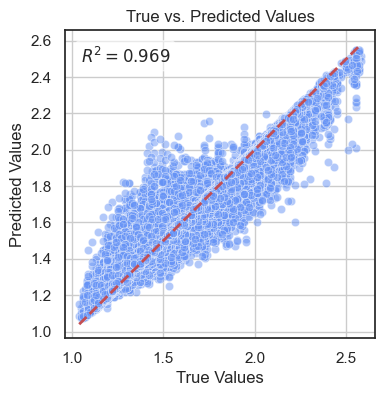

Evaluate on Test Set
Train set MSE: 0.002
Train set R^2: 0.946
Train set Spearman R: 0.972


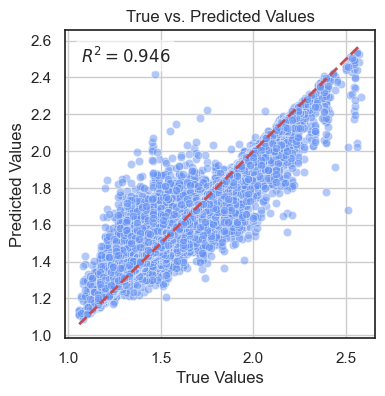

In [31]:
model = RandomForestRegressor(oob_score=False, random_state=seed, criterion='friedman_mse', max_depth=30, max_features='sqrt', n_estimators=100, max_samples=0.5, min_samples_leaf=2)
model.fit(X_train, y_train)

utils.evaluate_best_regressor(model, X_train, y_train, dataset="Training")

utils.evaluate_best_regressor(model, X_test, y_test, dataset="Test")

# Save the model
data_and_model = [data_train, data_test, model]

file = f'../models/reg_model_randomforest_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}.pickle'
with open(file, 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## XAI for Random Forest Regression Model

Next, we repeat the same XAI analysis with the regresison model to see if we get similar results to the classification model.  
We will use three different interpretability methods for our Random Forest model to understand which features are important for Rogue Wave prediction. 

### Load Data and Model

In [11]:
undersample = False
undersample_method = None
case = 3

model_type = "reg"

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})
Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})
Loaded the following model: RandomForestRegressor(criterion='friedman_mse', max_depth=30,
                      max_features='sqrt', max_samples=0.5, min_samples_leaf=2,
                      random_state=42) with an average tree depth of : 30.0
Train set MSE: 0.001
Train set R^2: 0.969
Train set Spearman R: 0.985


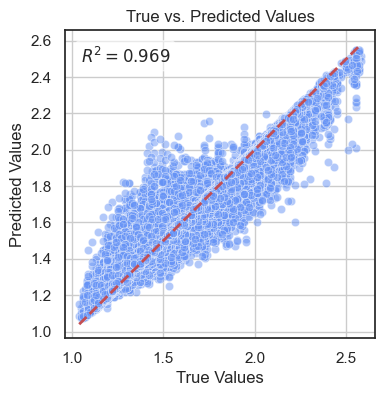

Test set MSE: 0.002
Test set R^2: 0.946
Test set Spearman R: 0.972


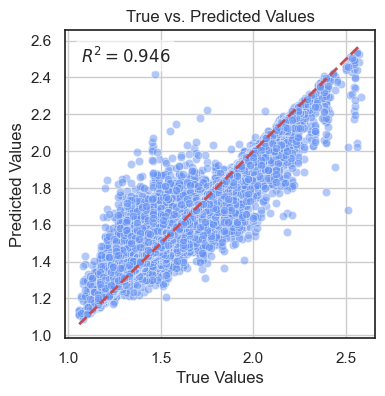

In [12]:
model, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model(model_type, case, undersample_method, undersample)

### Random Forest Feature Importance

The simplest way to explain a Random Forest model is the Random Forest specific feature importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute feature_importances_ .

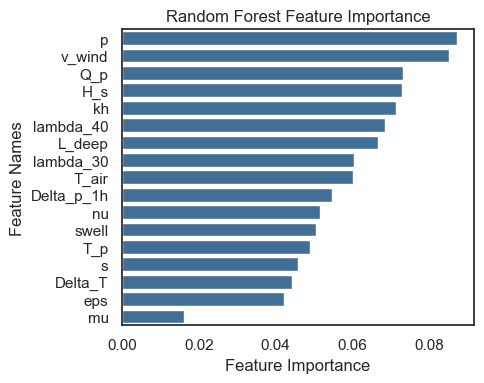

In [13]:
file_plot = f'../results/RFI_{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}.png'
utils.plot_impurity_feature_importance(model.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance", save=file_plot)

### SHAP

With SHAP we get contrastive explanations that compare the prediction with the average prediction. The global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations.

When using TreeExplainer for a Ranfom Forest model, there will be small variations between the average model prediction and the expected value from SHAP. This behaviour is explained as follows in this GitHub thread:

> It is because of how sklearn records the training samples in the tree models it builds. Random forests use a random subsample of the data to train each tree, and it is that random subsample that is used in sklearn to record the leaf sample weights in the model. Since TreeExplainer uses the recorded leaf sample weights to represent the training dataset, it will depend on the random sampling used during training. This will cause small variations like the ones you are seeing.

To get the exact same values, we would have to sample from the whole background dataset for integrating out features via the Independent masker. However, since the dataset is so large, we have to use a smaller background dataset where we expect to see some deviations from the average model prediction.

In addition, when using SHAP to explain a classifiers output, the default value in TreeExplainer for model_output="raw", which explains the raw output of the model. For regression models, "raw" is the standard output. 

In [14]:
# Sample 80,000 rows from the dataset to be able to run SHAP
n_samples_0 = 220000
n_samples_1 = 44000
n_samples_2 = 14000

rus = RandomUnderSampler(sampling_strategy={0: n_samples_0, 1: n_samples_1, 2: n_samples_2}, random_state=seed, replacement=False) 
X_sample, _ = rus.fit_resample(X_train, y_train_cat) 

In [ ]:
# Batch Processing
batch_size = 200
shap_values = []

print("Setup Explainer")

explainer = shap.TreeExplainer(model=model, model_output="raw", feature_perturbation="tree_path_dependent")

print("Batch compute SHAP values")

for i in tqdm(range(0, len(X_sample), batch_size)):
    X_batch = X_sample[i:i + batch_size]
    shap_values_batch = explainer.shap_values(X_batch)
    shap_values.append(shap_values_batch)

# Combine results
shap_values = np.concatenate(shap_values, axis=0)

Setup Explainer
Batch compute SHAP values


In [ ]:
shap.summary_plot(shap_values, X_sample)

### Forest-Guided Clustering

Forest-Guided Clustering (FGC) is an explainability method for Random Forest models. Standard explainability methods (e.g. feature importance) assume independence of model features and hence, are not suited in the presence of correlated features. The Forest-Guided Clustering algorithm does not assume independence of model features, because it computes the feature importance based on subgroups of instances that follow similar decision rules within the Random Forest model. Hence, this method is well suited for cases with high correlation among model features.

Since the dataset is very large, we run the FGC optimization with subsampling.

In [ ]:
data_fgc_reg = X_train.copy()
data_fgc_reg["target"] = y_train

In [ ]:
number_of_iterations = 20  # Number of times dataset will be subsampled
n_samples = 12000          # Number of samples in the subsampled dataset
max_K = 12                 # Maximum K for the FGC

k_result =  dict((i,0) for i in range(1, max_K+1)) # Dictionary to store the result

for i in range(number_of_iterations):
    print(f"Iteration: {i+1}")
    # sample the dataset
    rus = RandomUnderSampler(sampling_strategy={0: int(n_samples/3), 1: int(n_samples/3), 2: int(n_samples/3)}, random_state=seed, replacement=False) 
    data_fgc_reg_sample, _ = rus.fit_resample(data_fgc_reg, y_train_cat) 
    # instantiate the fgc object on the subsampled dataset and run it:
    fgc = FgClustering(model=model, data=data_fgc_reg_sample, target_column='target')
    fgc.run(max_K = max_K,
            method_clustering = 'pam', 
            discart_value_JI = 0.60, 
            bootstraps_JI = 100, 
            n_jobs = n_jobs, 
            verbose = 0,
            )
    # save the result
    k_result[fgc.k] += 1

In [ ]:
print('Results of k estimation:')
pd.DataFrame(k_result.items(), columns=['k','count']).sort_values(by='count', ascending=False).reset_index(drop=True)

In [ ]:
ks = [2]

fgc = FgClustering(model=model, data=data_fgc_reg, target_column="target")

for k in ks:
        fgc.run(k = k, 
                method_clustering = 'pam', 
                bootstraps_p_value = 100, 
                n_jobs = n_jobs, 
                verbose = 2
        )

        filename = f'../results/FGC_k{k}_{model_type}_model_randomforest_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}_test'

        fgc.plot_feature_importance(save=filename)
        fgc.plot_decision_paths(save=filename)

## Feature Selection

For the regression model we would like to reduce the number of required features, which would make it easier to use as forecasting model.  
Some of the recoded features are rather hard to measure, e.g. *lambda_30*, *lamda_40*, *s*, *Delta_T*, *nu*, *Q_p*, while other are easier to measure, e.g. *wind*, *Hs*, *p*, *swell*, *kh*, *T_air*, *L_deep*, *T_p*, *Delta_p_1h*.

### Load Data and Model

In [ ]:
undersample = False
undersample_method = None
case = 3

model_type = "reg"

In [ ]:
model_full, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model(model_type, case, undersample_method, undersample)

Check the correlation matrix to see if we have redundant features.

In [ ]:
utils.plot_correlation_matrix(X_train, figsize=(5, 5), annot=False, labelsize=8)

### Feature Selection with Recursive Feature Elimination

A Recursive Feature Elimination (RFE) example with automatic tuning of the number of features selected with cross-validation.  
For further information see:
- https://scikit-learn.org/1.5/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
- https://medium.com/@loyfordmwenda/recursive-feature-rfe-elimination-with-scikit-learn-d0d29e96273d

In [ ]:
# Define the regression model and use the hyperparameters from gridsearch for full regression model
params = model_full.get_params()

# initialize a new Random Forest Regressor with the same parameter settings
model = RandomForestRegressor(**params)

In [ ]:
# Define the RFE parameters
min_features_to_select = 1  # Minimum number of features to consider

In [ ]:
# Run RFE
skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train_cat)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=skf,
    scoring="r2",
    min_features_to_select=min_features_to_select,
    n_jobs=n_jobs,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {X_train.columns[rfecv.support_]}")

In [ ]:
# Plot results
cv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure(figsize=(8, 4))
plt.xlabel("Number of Selected Features")
plt.ylabel("Mean Test Score")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()

In [ ]:
pd.DataFrame({"feature removed": ["-"] + list(X_train.columns[rfecv.support_])[::-1], "mean test score":  list(cv_results["mean_test_score"])[::-1] + [0]})

### Sequential Feature Selection

SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score. That is, we start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.  
For further information see:

- https://scikit-learn.org/1.5/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py


In [ ]:
# Define the regression model and use the hyperparameters from gridsearch for full regression model
params = model_full.get_params()

# initialize a new Random Forest Regressor with the same parameter settings
model = RandomForestRegressor(**params)

In [ ]:
# Define the SFS parameters
tol = 0.05 # we use the r^2 score for a RandomForest Regressor
n_features_to_select = "auto"
direction = "forward"
scoring = "r2"

In [ ]:
# Run SFS
skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train_cat)
sfs = SequentialFeatureSelector(model, n_features_to_select=n_features_to_select, tol=tol, direction=direction, scoring=scoring, cv=skf)
sfs.fit(X_train, y_train)

print(f"Optimal number of features: {sfs.n_features_to_select_}")
print(f"Selected features: {X_train.columns[sfs.support_]}")

The sequential feature selector returns 2 features leading to the best score. The selected features are *v_wind* and *p*. Hence, we will retrain the RF model with only those features.

In [ ]:
top_features = ["v_wind", "p"]

print(f'Building model for case {case}' + f'{f" with {undersample_method} undersampled data" if undersample else ""} and top features: {top_features}.')
model.fit(X_train[top_features], y_train)

# Train performance
y_pred = model.predict(X_train[top_features])
y_true = y_train

print(f"\nTrain set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
print(f"Train set R^2: {round(r2_score(y_true, y_pred), 3)}")
print(f"Train set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

# Test performance
y_pred = model.predict(X_test[top_features])
y_true = y_test

print(f"\nTest set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
print(f"Test set R^2: {round(r2_score(y_true, y_pred), 3)}")
print(f"Test set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

### Combinatorial Feature Selection

We iterate through each feature combination with a fixed set of model parametes and check which combination of features leads to the best results.

In [ ]:
# Define the regression model and use the hyperparameters from gridsearch for full regression model
params = model_full.get_params()

In [ ]:
# Input list
features = X_train.columns

# Generate all combinations of all lengths
feature_combinations = []
for r in range(1, len(features) + 1):
    combinations = [list(comb) for comb in itertools.combinations(features, r)]
    feature_combinations.extend(combinations)

# Print the result
print("Number of combinations:", len(feature_combinations))

Number of combinations: 131071


In [ ]:
X_train, y_train, X_val, y_val = train_test_split(X_train, y_train, stratify=y_train_cat, train_size=0.80, random_state=seed)

X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

In [ ]:
results = pd.DataFrame(columns=["Features", "Train MSE", "Train R2", "Train Spearman R", "Test MSE", "Test R2", "Test Spearman R"])

for feature_combination in feature_combinations:
    print(f'Building model for case {case}' + f'{f" with {undersample_method} undersampled data" if undersample else ""} and features: {feature_combination}.')
    results["Features"] = feature_combination

    # initialize a new Random Forest Regressor with the same parameter settings
    model = RandomForestRegressor(**params)
    model.fit(X_train[feature_combination], y_train)

    # Train performance
    y_pred = model.predict(X_train[feature_combination])
    y_true = y_train

    results["Train MSE"] = round(mean_squared_error(y_true, y_pred), 3)
    results["Train R2"] = round(r2_score(y_true, y_pred), 3)
    results["Train Spearman R"] = round(spearmanr(y_true, y_pred).correlation, 3)

    # Test performance
    y_pred = model.predict(X_val[feature_combination])
    y_true = y_val

    results["Test MSE"] = round(mean_squared_error(y_true, y_pred), 3)
    results["Test R2"] = round(r2_score(y_true, y_pred), 3)
    results["Test Spearman R"] = round(spearmanr(y_true, y_pred).correlation, 3)